In [3]:
from pycocotools.coco import COCO
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from pathlib import Path, PurePath
import torch
import pandas as pd

import argparse
import json
import torchvision.transforms as T

import torchvision

from tqdm import tqdm

import seaborn as sns

from util.box_ops import box_iou, box_cxcywh_to_xyxy


from PIL import Image, ImageDraw, ImageFont


Bad key savefig.frameon in file /home/daniel/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file /home/daniel/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file /home/daniel/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log filename, sys.stdout or sys.stderr')
You probably need to get an updated m

In [4]:
annot_train_path_coco = "/cs/usr/segal/proj/coco/annotations/instances_train2017.json"
imgs_train_path_coco = "/cs/usr/segal/proj/coco/train2017"
annot_train_path_pvoc = "/cs/++/usr/segal/pvoc/annotations/instances_train_pvoc.json"
imgs_train_path_pvoc = "/cs/++/usr/segal/pvoc/images"
annot_val_path = "/cs/usr/segal/proj/coco/annotations/instances_val2017.json"

In [5]:
def get_test_stats_diff(q, q_prev):

    losses = ['test_loss', 'test_loss_bbox', 'test_class_error']

    loss_diff = {}

    for l in losses:
        loss_diff["diff_" + l] = q['eval_stats'][l] - q_prev['eval_stats'][l]

    return loss_diff

def get_test_losses(q):
    losses = ['test_loss', 'test_loss_bbox', 'test_class_error', 'test_coco_eval_bbox', 'mAP']
    
    loss_dict = {}
    for l in losses:
        loss_dict[l] = q['eval_stats'][l]

    return loss_dict



def get_area_box(box):
    x, y, w, h = box
    return w * h


def get_mean_n_boxes(outputs, n_cls):
    n = 0
    for i, output in enumerate(outputs):
        for logits, box in zip(output['pred_logits'][0], output['pred_boxes'][0]):
            cls = logits.argmax()
            if cls >= n_cls:
                continue
            # print("[overlaps] cls:", cls)
            n += 1
    return n / len(outputs)


def get_iou_means(outputs, n_cls):
    iou_img_means = []

    for i, output in enumerate(outputs):
        boxes = []
        for logits, box in zip(output['pred_logits'][0], output['pred_boxes'][0]):
            cls = logits.argmax()
            if cls >= n_cls:
                continue
            # print("[overlaps] cls:", cls)
            boxes.append(box)

        # iou over all pairs in the image
        ious = []
        for i in range(len(boxes)):
            for j in range(i + 1, len(boxes)):
                iou, union = box_iou(box_cxcywh_to_xyxy(boxes[i]).unsqueeze(0),
                                    box_cxcywh_to_xyxy(boxes[j]).unsqueeze(0))
                ious.append(iou[0].item())

        if len(ious) == 0:
            ious.append(0)

        iou_img_means.append(np.array(ious).mean())

    iou_means = np.array(iou_img_means).mean()
    print(iou_means)
    return iou_means


def get_features_means(outputs, n_cls, dict_funcs):
    # mean area of bounding boxes across all the fetched images
    # counting only areas where there were objects

    features = {}
    for k, v in dict_funcs.items():
        features[k] = np.array([])

    for i, output in enumerate(outputs):
        for logits, box in zip(output['pred_logits'][0], output['pred_boxes'][0]):
            cls = logits.argmax()
            if cls >= n_cls:
                continue
            #print("cls:", cls)
            for k, func in dict_funcs.items():
                features[k] = np.append(features[k], func(box))

    res = {}
    # aggregate
    for k, f in features.items():
        res[k] = f.mean()

    return res



def get_outputs(model, imgs_info, imgs_train_path):
    # standard PyTorch mean-std input image normalization
    transform = T.Compose([
        T.Resize(800),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    outputs = []
    model.eval()
    for i in range(len(imgs_info)):
        print(i)
        img_path = os.path.join(imgs_train_path, imgs_info[i]['file_name'])
        img = Image.open(img_path)
        img = transform(img).unsqueeze(0)
        out = model(img)
        outputs.append(out)

    print('finishing running model on images')
    return outputs


def get_features(imgs_info, imgs_train_path):
    model = torchvision.models.resnet18(pretrained=True)
    
    feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])

    
    feature_extractor.eval()
    
    transform = T.Compose([
        T.Resize(224),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    outputs = []
    model.eval()
    for i in range(len(imgs_info)):
        if i % 100 == 0:
            print("{}/{}".format(i, len(imgs_info)))
        img_path = os.path.join(imgs_train_path, imgs_info[i]['file_name'])
        img = Image.open(img_path)
        img = transform(img).unsqueeze(0)
        out = feature_extractor(img)
        outputs.append(out)

    print('finishing running model on images')
    return outputs


    


In [60]:

    
def plot_means(logs_dir, dates, max_cycles=7):
    df = pd.DataFrame({"log":[],
                       "cycle": [],
                       "method": [],
                       "seed": [],
                       "dataset": [],
                       "val_size": [],
                   #"test_loss": [],
                    'test_loss_bbox': [],
                    'test_class_error': [],
                    'test_mAP': []
                   })

    dir_path = Path(logs_dir)

    log_dirs = []
    for date in dates:
        log_dirs = log_dirs + [pth for pth in dir_path.iterdir() if date in pth.name]
        

    f_name = "run_data.json"
    n_method = {}
    
    
    noise_dict = {1: "high_noise", 10: "medium_noise", 100: "low_noise"}
    for log in log_dirs:
        # iterations over cycles - row in the dataframe
        path = os.path.join(log, f_name)
        with open(path, 'r') as f:
            data = json.load(f)

        queries = data['queries_data']
        method = data['args']['al_method']
        
        if method == "cls_hardness":
            if 'with_noise' in data['args']:
                if data['args']['with_noise'] == "True":
                    inv_var = data['args']['inv_var']
                    method = "{}_{}".format(method, noise_dict[inv_var])
                    has_inv_var = True
                else:
                    method = "{}_{}".format(method, "no_noise")
                    has_inv_var = False
                    
            elif 'inv_var' in data['args']:
                inv_var = data['args']['inv_var']
                method = "{}_{}".format(method, noise_dict[inv_var])
                has_inv_var = True
            else:
                method = "{}_{}".format(method, "no_noise")
                has_inv_var = False
                
        elif method=="random":
            has_inv_var = False
                
        if method in n_method:
            n_method[method] += 1
        else:
            n_method[method] = 1
            

        metrics = {'test_loss_bbox':[], 'test_class_error':[], 'test_mAP':[]}
        perfs = {}

        for metric in metrics.keys():
            if "mAP" in metric:
                ewm_col = 0
                # dropna()?
                y = [q['eval_stats']["test_coco_eval_bbox"] for q in queries]
                y = np.array(y)
                coco_eval = pd.DataFrame(
                    y[:, 1]
                ).ewm(com=ewm_col).mean()

                y = np.array(coco_eval).flatten()
                
            else:
                y = [q['eval_stats'][metric] for q in queries]

            perfs[metric] = y
        
        
        
        seed = data["args"]["seed"]
        dataset = data["args"]["dataset_file"]
        
        if 'val_sz' in data["args"]:
            val_size = int(data['args']['val_sz'])
        else:
            val_size = -1
            

        l = len(queries)
        entries = pd.DataFrame({"log": [log] * l,
                                **perfs, "cycle": np.arange(0, l),
                                "method": [method] * l, "seed": [seed] * l,
                                "dataset": [dataset] * l, "val_size": [val_size] * l
                                })


        df = pd.concat([df, entries])

    methods = set(df['method'])

    df["seed"] = df["seed"].astype(int)
    return df, n_method




In [61]:

log_dir = "/home/daniel/project/ALCH/logs"
dataset_path = "/home/daniel/project/pvoc"


In [62]:

dates = ["08", "06.09", "09.09", "10.09"]
df, n_method = plot_means(log_dir, dates)

metrics = {'test_loss_bbox':[], 'test_class_error':[], 'test_mAP':[]}
methods = set(df['method'])


# of entries: 119
--------------------
#runs for each method
{'random': 7, 'cls_hardness_no_noise': 7, 'cls_hardness_high_noise': 1, 'cls_hardness_medium_noise': 1, 'cls_hardness_low_noise': 1}


# Clshardness vs Random

In [64]:
#df['method'].replace({"cls_hardness_no_noise": "class_hardness", "cls_hardness_low_noise": "class_hardness"}, inplace=True)
df['method'].replace({"cls_hardness_no_noise": "ALCH"}, inplace=True)

df_f = df[(df['seed'] == 83) | (df['seed'] == 99) | (df['seed'] == 65) | (df['seed'] == 1024)]
#df_f = df[df['seed'] in seeds]
df_f = df_f[(df_f['method'] == 'random') | (df_f['method'] == 'ALCH')]


df_f = df_f[df_f['cycle'] != 7.0] # most runs didn't reach 7 cycle

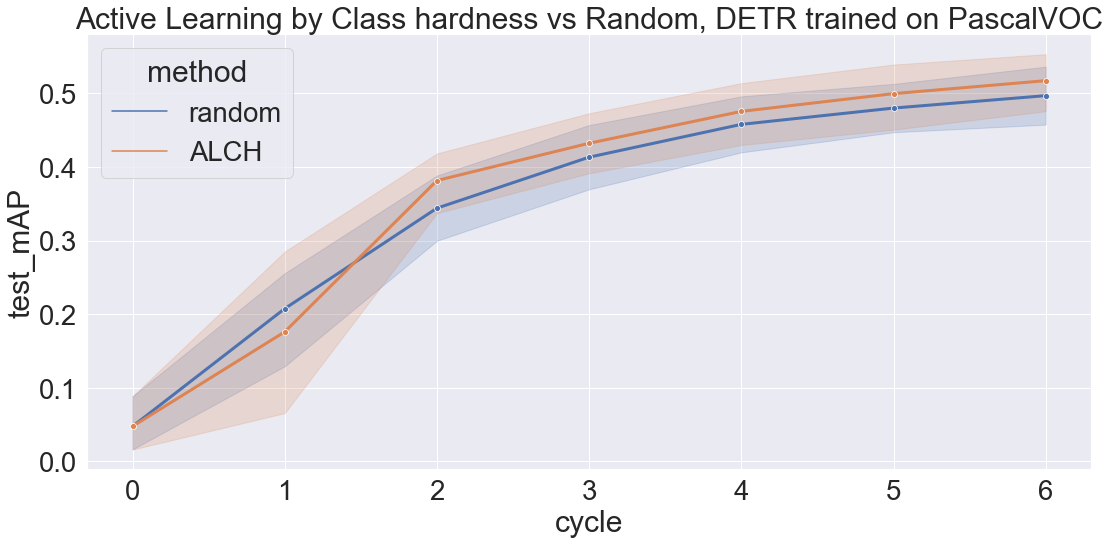

In [66]:
sns.set(rc={'figure.figsize':(18, 8)})
sns.set(font_scale=2.5)
title = "Active Learning by Class hardness vs Random, DETR trained on PascalVOC"
sns.lineplot(data=df_f, x='cycle', y="test_mAP", hue="method", marker='o', linewidth=3, n_boot=1000).set_title(title)
plt.savefig('AL_vs_random_pvoc.png')


In [76]:
from sklearn.linear_model import LinearRegression 
def get_coef(X, y):
    reg = LinearRegression().fit(X, y)
    slope = reg.coef_[0]
    return slope

coefs = {'random': [], 'ALCH': []}

for log in df_f['log'].unique():
    method = df_f.loc[df_f['log'] == log, 'method'][0]
    test_map = df_f.loc[(df_f['log']==log) & (df_f['method'] == method), 'test_mAP']
    coef = get_coef(np.arange(7).reshape(-1,1), test_map)
    coefs[method].append(coef)


In [78]:
coefs

{'random': [0.055967878722086674,
  0.08039728763563304,
  0.08896838537903831,
  0.061321224609718575],
 'ALCH': [0.09496230305520144,
  0.04895612959789424,
  0.09438914408355989,
  0.06884144978766045]}

In [ ]:
# R code for testing:
'''
coefs_alch_pvoc = c(0.09496230305520144,
0.04895612959789424,
0.09438914408355989,
0.06884144978766045)

coefs_random_pvoc = c(0.055967878722086674,
                      0.08039728763563304,
                      0.08896838537903831,
                      0.061321224609718575)
wilcox.test(coefs_alch_pvoc, coefs_random_pvoc, alternative="greater")
'''

In [15]:
df_m['seed'].unique()[0]


83

# ALCH - Validation as test - DETR on PascalVOC

In [284]:
dates = ["08", "09"]
log_dir = "/media/daniel/Windows10_OS/win_alch/backup_31.8"

df, n_method = plot_means(log_dir, dates)


df_res = df[df['dataset'] == 'pvoc']
df_res.head()


val_is_test_log = Path('/media/daniel/Windows10_OS/win_alch/backup_31.8/cls_hardness_val_is_test_25.08_12_19_log')
df_res = df_res[(df_res['log'] == val_is_test_log) | (df_res['val_size'] == 1000.0) | (df_res['val_size'] == 2000.0) | (df_res['val_size'] == 500.0)]

df_res = df_res[df_res['seed'] == 65]

df_res.loc[(df_res['log'] == val_is_test_log), 'method'] = "validation=test"

df_res.loc[(df_res['val_size'] == 500.0), 'method'] = "class_hardness_validation_size=500"

df_res.loc[(df_res['val_size'] == 1000.0), 'method'] = "class_hardness_validation_size=1000"
df_res.loc[(df_res['val_size'] == 2000.0) & (df_res['method'] != 'random'), 'method'] = "class_hardness_validation_size=2000"
df_res.loc[(df_res['log'] == val_is_test_log), 'method'] = "validation=test"




# of entries: 44
--------------------
#runs for each method
{'cls_hardness_no_noise': 5, 'cls_hardness_high_noise': 1, 'random': 1}


Text(0.5, 1.0, 'Varying validation size and validation=test')

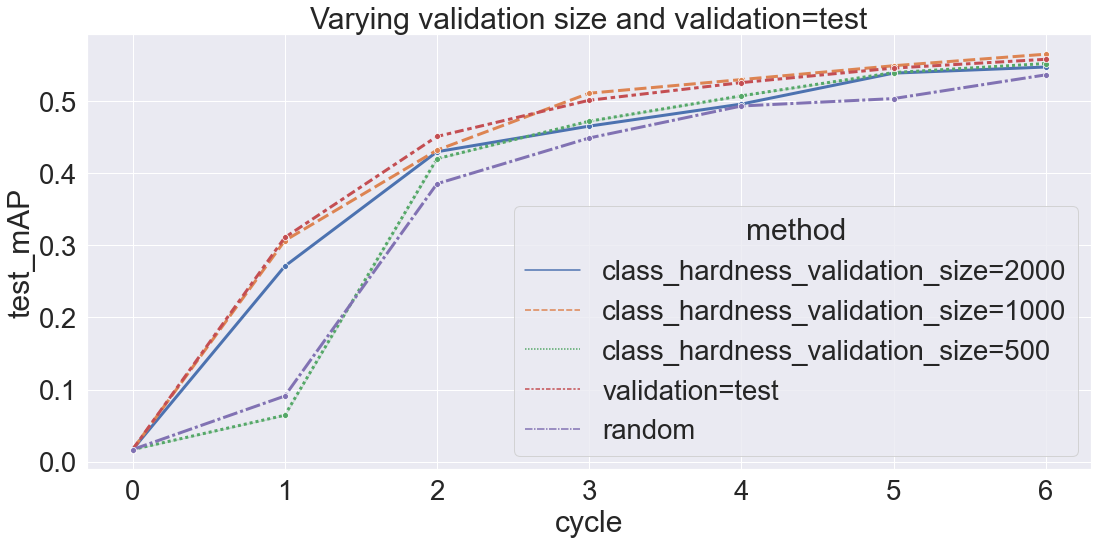

In [299]:
title = "Varying validation size and validation=test"
sns.lineplot(data=df_res, x="cycle", y="test_mAP", hue="method", marker='o', style='method', dashes=True, linewidth=3).set_title(title)

# ALCH - DETR on KITTI

In [31]:

dates = ["08", "09"]
log_dir = "/media/daniel/Windows10_OS/win_alch/kitti_logs"

df, n_method = plot_means(log_dir, dates)


df['method'].replace({"cls_hardness_no_noise": "ALCH"}, inplace=True)

df_res = df[df['dataset'] == 'kitti']



# of entries: 72
--------------------
#runs for each method
{'random': 4, 'cls_hardness_no_noise': 4}


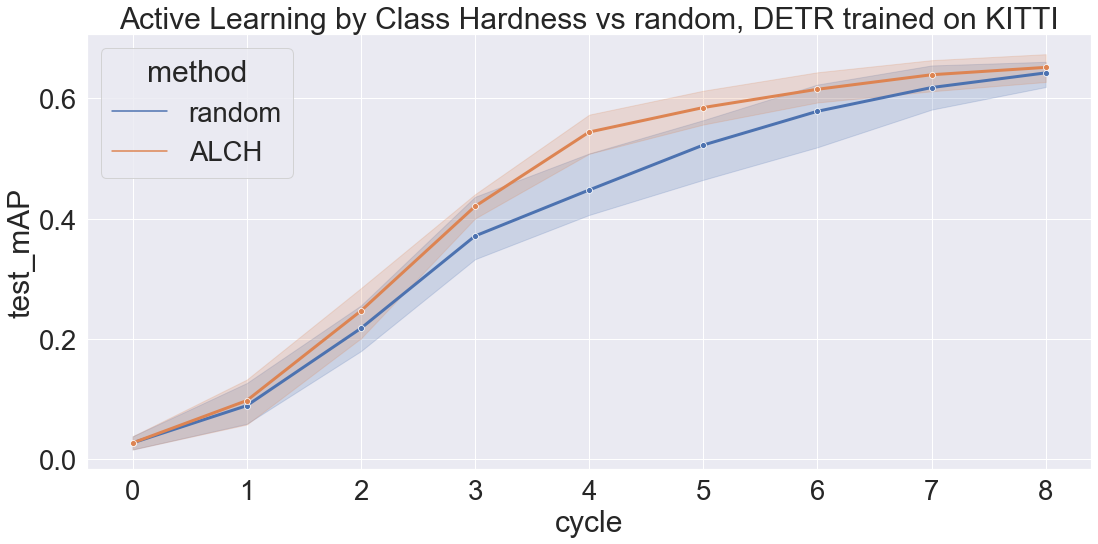

In [32]:
title = "Active Learning by Class Hardness vs random, DETR trained on KITTI"
#sns.lineplot(data=df_res, x="cycle", y="test_mAP", hue="method").set_title(title)
sns.lineplot(data=df_res, x='cycle', y="test_mAP", hue="method", marker='o', linewidth=3).set_title(title)
plt.savefig('AL_vs_random_kitti.png')


In [80]:
from sklearn.linear_model import LinearRegression 
df_f = df_res.copy()
def get_coef(X, y):
    reg = LinearRegression().fit(X, y)
    slope = reg.coef_[0]
    return slope

coefs = {'random': [], 'ALCH': []}

for log in df_f['log'].unique():
    method = df_f.loc[df_f['log'] == log, 'method'][0]
    test_map = df_f.loc[(df_f['log']==log) & (df_f['method'] == method), 'test_mAP']
    coef = get_coef(np.arange(9).reshape(-1,1), test_map)
    coefs[method].append(coef)
    
coefs

{'random': [0.0849610474512318,
  0.09265802434028858,
  0.08258176648301324,
  0.06781407882709539],
 'ALCH': [0.08710498187225214,
  0.09224479118196502,
  0.0776978786781154,
  0.07786263471403863]}

In [ ]:
# R code for testing:
'''
coefs_random_kitti = c(0.0849610474512318,
                    0.09265802434028858,
                    0.08258176648301324,
                    0.06781407882709539)


coefs_alch_kitti = c(0.08710498187225214,
                     0.09224479118196502,
                     0.0776978786781154,
                     0.07786263471403863)


wilcox.test(coefs_alch_kitti, coefs_random_kitti, alternative="greater")
'''